## EVAN HAUZAL FADHILA 
L0224041

B

RESPONSI PDS

## SIMULASI HARGA BITCOIN MENGGUNAKAN MONTE CARLO
dengan menggunakan data harga bitcoin dari tahun 2014 sampai tahun 2025


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [9]:
df = pd.read_csv("/kaggle/input/betece/BTC_HISTORICAL_YFINANCE.csv") 

In [10]:
df = pd.read_csv("/kaggle/input/betece/BTC_HISTORICAL_YFINANCE.csv")

df = df.dropna(subset=["Date"])

numeric_cols = ["Close", "High", "Low", "Open", "Volume"]
df[numeric_cols] = df[numeric_cols].astype(float)

df.columns = ["Date", "Close", "High", "Low", "Open", "Volume"]
df["Date"] = pd.to_datetime(df["Date"])

df[numeric_cols] = df[numeric_cols].round(2)

df.head()

,Date,Close,High,Low,Open,Volume
1,2014-09-17,457.33,468.17,452.42,465.86,21056800.0
2,2014-09-18,424.44,456.86,413.10,456.86,34483200.0
3,2014-09-19,394.80,427.83,384.53,424.10,37919700.0
4,2014-09-20,408.90,423.30,389.88,394.67,36863600.0
5,2014-09-21,398.82,412.43,393.18,408.08,26580100.0


untuk visualisasi candle stik, MA, dan SMA ini saya ambil code nya dari salah satu exchange yang menawarkan open resources yaitu CoinGecko
https://www.coingecko.com/learn/category/api

In [11]:
def load_data(csv_path):
    df = pd.read_csv(csv_path)

    df.columns = [c.split()[0] for c in df.columns]

    df = df.dropna(subset=["Date"])

    df["Date"] = pd.to_datetime(df["Date"], errors="coerce")
    df = df.dropna(subset=["Date"])

    num_cols = ["Close", "High", "Low", "Open", "Volume"]
    df[num_cols] = df[num_cols].astype(float)

    df = df.sort_values("Date").reset_index(drop=True)

    df.columns = df.columns.str.lower()

    return df

In [12]:
def add_sma(df, window_short, window_long):
    df["sma_short"] = df["close"].rolling(window_short).mean()
    df["sma_long"] = df["close"].rolling(window_long).mean()
    return df

In [13]:
def plot_candlestick_sma(df, window_short, window_long):

    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=df["date"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name='OHLC'
    ))

    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["sma_short"],
        mode='lines',
        line=dict(color='blue'),
        name=f"SMA {window_short}"
    ))

    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["sma_long"],
        mode='lines',
        line=dict(color='orange'),
        name=f"SMA {window_long}"
    ))

    fig.update_layout(
        title=f"Candlestick + SMA {window_short} & {window_long}",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        height=600
    )

    fig.show()

## VISUALISASI DATA ASLI HARGA BTC 2014 - 2025

In [14]:
df = load_data("/kaggle/input/betece/BTC_HISTORICAL_YFINANCE.csv")
df = add_sma(df, 50, 200)
plot_candlestick_sma(df, 50, 200)

## SIMULASI MONTE CARLO

In [15]:
df = df[['date', 'close', 'high', 'low', 'open', 'volume']]
df.columns = ['date', 'close', 'high', 'low', 'open', 'volume']

## Cleaning & Tipe Data

In [16]:
df = df[['date', 'close', 'high', 'low', 'open', 'volume']].copy()

df.loc[:, 'date'] = pd.to_datetime(df['date'], errors='coerce')

numeric_cols = ['close', 'high', 'low', 'open', 'volume']

for col in numeric_cols:
    df.loc[:, col] = (
        df[col]
        .astype(str)
        .str.replace(",", "", regex=False)
        .str.replace("USD", "", regex=False)
        .str.replace("BTC-USD", "", regex=False)
        .str.strip()
        .replace("", np.nan)
        .astype(float)
    )


df = df.sort_values('date').dropna()

## Hitung Log Return

In [17]:
df['log_return'] = np.log(df['close'] / df['close'].shift(1))
df = df.dropna()

print(df['log_return'].tail())

4083   -0.017950
4084   -0.005212
4085    0.025159
4086    0.016742
4087   -0.007011
Name: log_return, dtype: float64


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning:

invalid value encountered in log



## Visualisasi Log Return

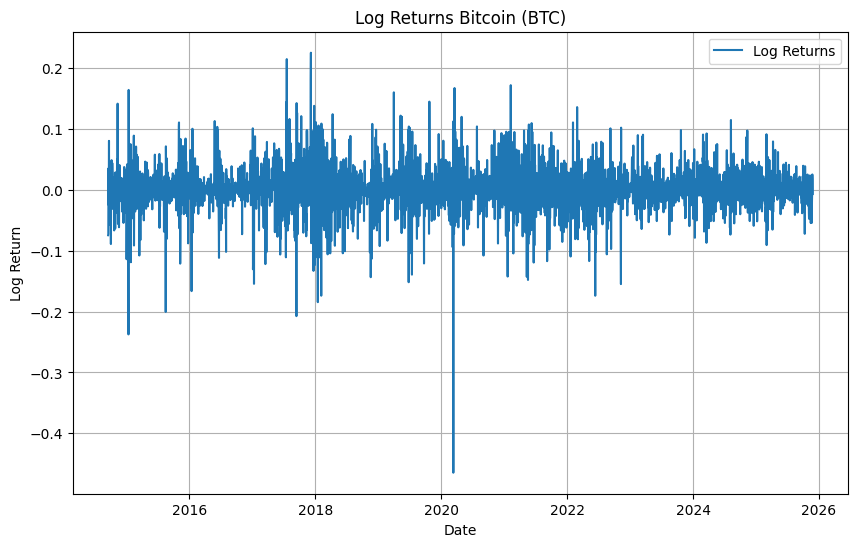

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['log_return'], label='Log Returns')
plt.title('Log Returns Bitcoin (BTC)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.show()

Disini bisa dilihat pada tahun 2020 memiliki log return yang extreme karena pada tahun itu terjadi beberapa peristiwa yang mengakibatkan penurunan harga bitcoin yang signifikan yaitu altcoin season dan juga pandemi covid 19

## Estimasi Parameter Monte Carlo

In [19]:
mu = df['log_return'].mean()
sigma = df['log_return'].std()

print(f"Mean (μ): {mu}")
print(f"Volatility (σ): {sigma}")

Mean (μ): 0.0012859644781024041
Volatility (σ): 0.03552381675868391


## Simulasi Monte Carlo (30 Hari)

In [20]:
last_price = df['close'].iloc[-1]
days = 30
n_simulations = 10000

simulation = np.zeros((n_simulations, days))

for i in range(n_simulations):
    price = last_price
    for d in range(days):
        shock = np.random.normal(mu, sigma)
        price = price * np.exp(shock)
        simulation[i, d] = price

## Visualisasi Jalur Monte Carlo

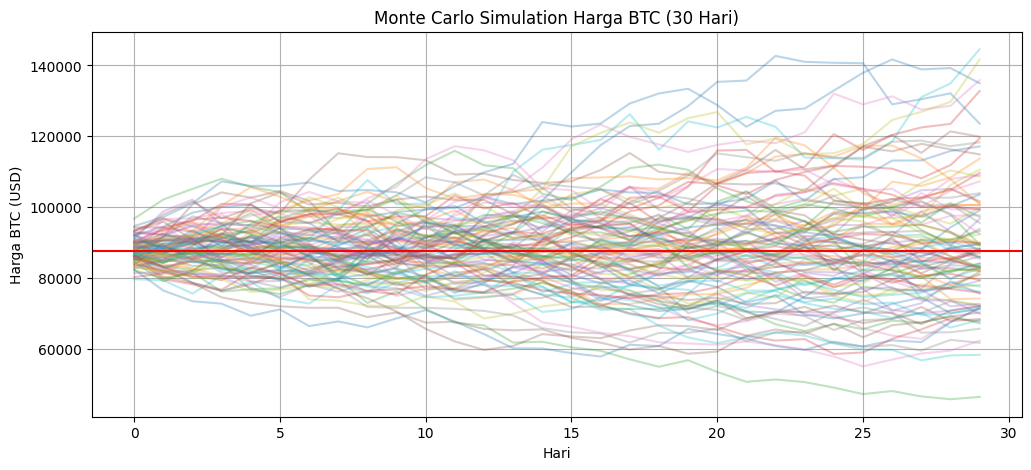

In [21]:
plt.figure(figsize=(12, 5))
plt.plot(simulation[:100].T, alpha=0.3)
plt.title("Monte Carlo Simulation Harga BTC (30 Hari)")
plt.axhline(y = last_price, color = 'r', linestyle= '-')
plt.xlabel("Hari")
plt.ylabel("Harga BTC (USD)")
plt.grid(True)
plt.show()

## Hitung VaR & CVaR (95%)

In [22]:
final_prices = simulation[:, -1]
returns = (final_prices - last_price) / last_price

VaR_95 = np.percentile(returns, 5)
CVaR_95 = returns[returns <= VaR_95].mean()

print("VaR 95% :", VaR_95)
print("CVaR 95%:", CVaR_95)

VaR 95% : -0.24407162614891628
CVaR 95%: -0.30067591706632835


## Visualisasi Distribusi Return + Risiko

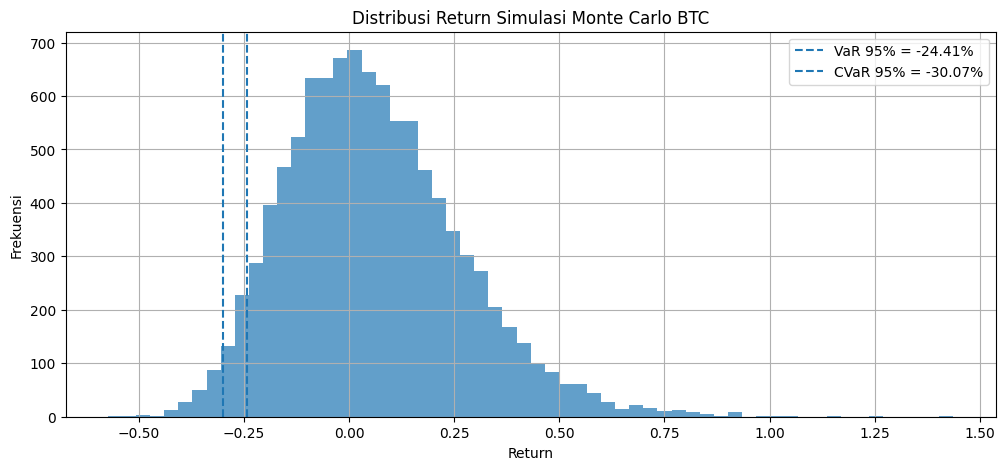

In [23]:
plt.figure(figsize=(12, 5))
plt.hist(returns, bins=60, alpha=0.7)
plt.axvline(VaR_95, linestyle='--', label=f"VaR 95% = {VaR_95:.2%}")
plt.axvline(CVaR_95, linestyle='--', label=f"CVaR 95% = {CVaR_95:.2%}")
plt.title("Distribusi Return Simulasi Monte Carlo BTC")
plt.xlabel("Return")
plt.ylabel("Frekuensi")
plt.legend()
plt.grid(True)
plt.show()

## MASUKAN HASIL SIMULASI MONTE CARLO KE CANDLE STICK

In [24]:
simulation

array([[ 91981.6257996 ,  94503.35387177,  98414.32747624, ...,
         84793.32727104,  84273.67454681,  88058.96128691],
       [ 87996.51828051,  86992.35763137,  85387.81091121, ...,
         85644.84133845,  85585.03892998,  82109.1904853 ],
       [ 82148.06272624,  79852.39970605,  81512.8565629 , ...,
         46524.36344802,  45734.62740059,  46391.89019078],
       ...,
       [ 88279.37536724,  86052.80366996,  87826.10653687, ...,
        109891.87864281, 106955.98845536, 110829.47630153],
       [ 89624.19160963,  87690.04902303,  91167.15242326, ...,
         98128.81890312,  98474.1667027 ,  99393.08062536],
       [ 82445.78759967,  81231.20008526,  86176.17834397, ...,
         93624.74677743,  92788.98844463,  95602.18107877]])

In [25]:
mc_mean = simulation.mean(axis=0)
mc_p5   = np.percentile(simulation, 5, axis=0)
mc_p95  = np.percentile(simulation, 95, axis=0)

In [26]:
last_date = df['date'].iloc[-1]
future_dates = pd.date_range(
    start=last_date + pd.Timedelta(days=1),
    periods=len(mc_mean),
    freq='D'
)

In [27]:
def plot_candlestick_sma_mc(df, window_short, window_long,
                            future_dates, mc_mean, mc_p5, mc_p95):

    fig = go.Figure()

    fig.add_trace(go.Candlestick(
        x=df["date"],
        open=df["open"],
        high=df["high"],
        low=df["low"],
        close=df["close"],
        name='OHLC'
    ))

    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["sma_short"],
        mode='lines',
        name=f"SMA {window_short}"
    ))

    fig.add_trace(go.Scatter(
        x=df["date"],
        y=df["sma_long"],
        mode='lines',
        name=f"SMA {window_long}"
    ))

    fig.add_trace(go.Scatter(
        x=future_dates,
        y=mc_mean,
        mode='lines',
        name='Monte Carlo Mean',
        line=dict(dash='dash')
    ))

    fig.add_trace(go.Scatter(
        x=np.concatenate([future_dates, future_dates[::-1]]),
        y=np.concatenate([mc_p95, mc_p5[::-1]]),
        fill='toself',
        name='MC 90% CI',
        opacity=0.2,
        line=dict(width=0)
    ))

    fig.update_layout(
        title="Candlestick + SMA + Monte Carlo Projection",
        xaxis_title="Date",
        yaxis_title="Price (USD)",
        xaxis_rangeslider_visible=False,
        height=650
    )

    fig.show()

In [28]:
df = load_data("/kaggle/input/betece/BTC_HISTORICAL_YFINANCE.csv")
df = add_sma(df, 50, 200)

df = df[df['date'] >= '2025-07-01'].reset_index(drop=True)

plot_candlestick_sma_mc(
    df,
    window_short=50,
    window_long=200,
    future_dates=future_dates,
    mc_mean=mc_mean,
    mc_p5=mc_p5,
    mc_p95=mc_p95
)

DISINI HASIL SIMULASI MONTE CARLO HA1. NYA BISA MENAMPILKAN GARIS PUTUS PUTUS BERWARNA UNGU, DAN TIDAK BISA MENAMPILKAN CANDLE STICK KARENA PER CANDLE STICK DIHASILKAN DARI BEBERAPA VARIABEL YAITU CLOSE OPEN HIGH DAN LOW, MONTE CARLO HANYA MENGHASILKAN HARGA CLOSE MAKA HANYA BISA MENGGAMBARKAN KEMANA ARAH PERGERAKAN HARGA SELANJUTNYA.